In [1]:
import math
import random
import operator

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from utils import create_city_graph, plot_distance_fitness_progress

In [3]:
plt.style.use('seaborn')

## Setup City

In [4]:
class City(object):
    """Defince City distance."""
    
    def __init__(self, x, y):
        
        self.x = x
        self.y = y
        
    def get_distance(self, city):
        
        # gene of a city represented as coordinates
        x_dist = abs(self.x - city.x)
        y_dist = abs(self.y - city.y)
        
        # calculate using Pythagorean theorem
        distance = np.sqrt((x_dist ** 2) + (y_dist ** 2))
        
        return distance
        
    def __repr__(self):
        return '(' + str(self.x) + ',' + str(self.y) + ')'

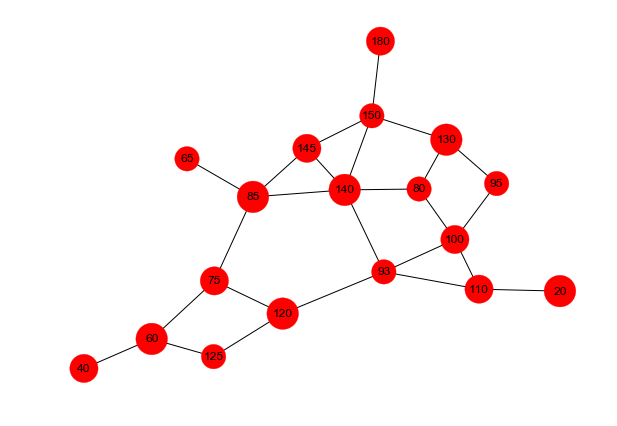

In [5]:
city_list = []
for i in range(0, 25):
    city_list.append(City(x=int(random.random()*200), y=int(random.random()*200)))
    
city_graph = create_city_graph(city_list)

city_list = []
for city in city_graph:
    city_list.append(City(x=city[0], y=city[1]))

## Define GA

In [6]:
class GeneticAlgorithm(object):
    """Generate GA for Traveling Salesman problem."""
    
    def __init__(self, num_generations=500):
        
        self.name = 'GA for Traveling Salesman problem.'
        print('GA for Traveling Salesman problem successfully initialized.')
        
        self.distance = 0
        self.fitness_score = 0.0
        
        self.route = []
        self.num_generations = num_generations
    
    def generate_population(self, city_list, population_size):
        
        population = []
        
        for i in range(0, population_size):
            population.append(random.sample(city_list, len(city_list)))
            
        return population
    
    def get_route_distance(self, route):
        
        if self.distance == 0:
            
            path_distance = 0
            for i in range(0, len(self.route)):
                
                from_city = self.route[i]
                to_city = None
                
                # need to start and end at the same city
                if i+1 < len(self.route):
                    to_city = self.route[i + 1]
                else:
                    to_city = self.route[0]
                    
                path_distance += from_city.get_distance(to_city)
            self.distance = path_distance
            
        return self.distance
    
    def get_route_fitness(self, route):
        
        self.distance = 0
        self.fitness_score = 0.0

        self.route = route
        
        if self.fitness_score == 0:
            self.fitness_score = 1 / float(self.get_route_distance(self.route))
            
        return self.fitness_score
    
    def get_rank_routes(self, population):
        
        fitness_results = {}
        
        for i in range(0, len(population)):
            fitness_results[i] = self.get_route_fitness(population[i])
            
        rank_routes = sorted(fitness_results.items(), key=operator.itemgetter(1), reverse=True)
        return rank_routes
    
    def select_parents(self, population_ranked, elite_size):
        
        selection_results = []
        df_fitness = pd.DataFrame(np.array(population_ranked), columns=['Index', 'Fitness'])
        df_fitness['cum_sum'] = df_fitness['Fitness'].cumsum()
        df_fitness['cum_perc'] = 100*df_fitness['cum_sum']/ df_fitness['Fitness'].sum()
        
        for i in range(0, elite_size):
            selection_results.append(population_ranked[i][0])
        
        # setup the roulette wheel selection
        for i in range(0, len(population_ranked) - elite_size):
            
            pick = 100*random.random()
            
            for i in range(0, len(population_ranked)):
                if pick <= df_fitness.iat[i, 3]:
                    selection_results.append(population_ranked[i][0])
                    break
                    
        return selection_results
    
    def crossover(self, mating_pool, elite_size):
    
        children = []
        length = len(mating_pool) - elite_size
        pool = random.sample(mating_pool, len(mating_pool))

        for i in range(0, elite_size):
            children.append(mating_pool[i])

        # setup ordered crossover
        for i in range(0, length):

            parent1 = pool[i]
            parent2 = pool[len(mating_pool)-i-1]

            child = []
            child_parent1 = []
            child_parent2 = []

            geneA = int(random.random() * len(parent1))
            geneB = int(random.random() * len(parent1))

            start_gene = min(geneA, geneB)
            end_gene = max(geneA, geneB)

            for i in range(start_gene, end_gene):
                child_parent1.append(parent1[i])

            # one city needs to be visited exactly one time
            child_parent2 = [item for item in parent2 if item not in child_parent1]

            child = child_parent1 + child_parent2
            children.append(child)

        return children
    
    def mutate(self, population, mutation_rate):
    
        mutated_population = []

        # s
        for index in range(0, len(population)):
            
            individual = population[index]
            
            for swapped in range(len(individual)):

                if(random.random() < mutation_rate):

                    swap_with = int(random.random() * len(individual))

                    city1 = individual[swapped]
                    city2 = individual[swap_with]

                    individual[swapped] = city2
                    individual[swap_with] = city1

            mutated_index = individual
            mutated_population.append(mutated_index)

        return mutated_population
    
    def create_next_generation(self, population, elite_size, mutation_rate):
        
        population_ranked = self.get_rank_routes(population)
        selection_results = self.select_parents(population_ranked, elite_size)
        
        mating_pool = []
        for i in range(0, len(selection_results)):
            index = selection_results[i]
            mating_pool.append(population[index])
        
        children = self.crossover(mating_pool, elite_size)
        next_generation = self.mutate(children, mutation_rate)
        
        return next_generation
    
    def reproduce(self, population, population_size, elite_size, mutation_rate):
        
        population = self.generate_population(population, population_size)
        
        print('Initial Distance: ' + str(1 / self.get_rank_routes(population)[0][1]))
        
        for i in range(0, self.num_generations):
            population = self.create_next_generation(population, elite_size, mutation_rate)
            
        print('Final Distance: ' + str(1 / self.get_rank_routes(population)[0][1]))
        best_route_index = self.get_rank_routes(population)[0][0]
        best_route = population[best_route_index]
        
        return best_route

In [7]:
GA = GeneticAlgorithm(num_generations=500)

GA for Traveling Salesman problem successfully initialized.


## Train GA

In [8]:
best_route = GA.reproduce(population=city_list, population_size=100, elite_size=20, mutation_rate=0.01)

Initial Distance: 1152.4188299203722
Final Distance: 550.5677033718603


## Evaluate GA

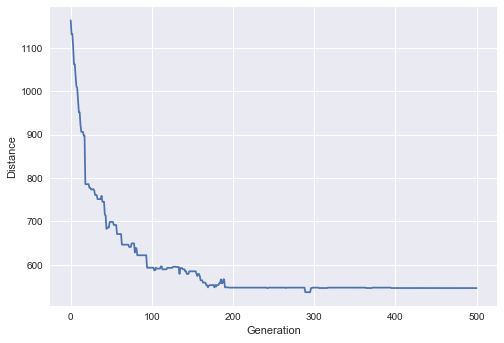

In [9]:
plot_distance_fitness_progress(algo=GA, population=city_list, population_size=100, elite_size=20, mutation_rate=0.01)

---